# Bagging and Boosting

## Commonalities
- Bagging and boosting are both ensembling techniques.
    - Combination of weak learners to build a strong learner
- Can be applied to classifiers or regressors
    - Combine models result via averaging or voting to produce a single final result

## Disambiguation

||Bootstrap Aggregation\* (Bagging)|Boosting|
|-|:-:|:-:|:-:|
|**Sampling**|Bootstrap (random sample with replacement)|All data used|
|**Modelling**|Used with low-bias/high-variance models like fully-grown decision trees (e.g. random forest). Models are trained _in parallel_ with datasets/attributes that differ as they are created by sampling with replacement|Sequential building of weak learners (high-bias/low variance, e.g. shallow trees). Subsequent weak learners are trained by adjustings weights based on residuals of previous weak learners (adaboost) or trained on the residuals directly (gbm) |
|**Error reduction focus**|Variance reduction with small negative impact on bias|Bias reduction|

## Bagging
### Simple (but not so good) example

Let original sample with size _n_ be: $$D=(x_1,x_2,...,x_n)$$

Decide on bootstrap number _k_. Sample _k_ number of samples with replacement from _D_.

Average the results of each function/model _f_:
$$f(D) = \frac{1}{k}\sum_{i=1}^{k} f(D_i)$$

In [397]:
m = np.random.randint(1,100,500)
print('population σ: ' + str(np.std(m)))

population σ: 29.1840753837


In [388]:
s = np.random.choice(m, size=100, replace=False)
print('sample mean: ' + str(np.std(s)))

sample mean: 29.374374887


In [396]:
B = []
for _ in range(50000):
    b = np.random.choice(s, size=100, replace=True)
    B.append(b)
print('mean from bagging: ' + str(np.std(B)))

mean from bagging: 29.3706247063


### Bagging in Random Forest

Step 1: From dataset with _N_ cases, samples _N_ cases with replacement (like bootstrapping above)

Step 2: Given _M_ number of attributes. _m_ (_m<<M_) number of attributes are selected at each node at random for splitting.

Step 3: Fully grow a tree without pruning.

Step 4: Repeat with until desired number of trees (forest) is achieved.

Step 5: Ensemble results

## Boosting

$$f(x)=\sum_{t}{\alpha_t h_t(x)} $$


### Gradient boosting

$$ \frac{1}{2}(y-F(x))^2 $$

Adaboost. 

Adaboost changes the weight of samples to let algorithm pays more attention on wrong classified samples. Take a regression problem as an example. It starts with equal weight for all simples, such as 1/n. Then it fits a decision tree on the data, sum the weight of misclassified samples. Compute the contribution of this classifier by sum weight of misclassified samples. Update the weight by contribution to all samples. Fit the residual of the first model by another decision tree, and update the weight as previous step. Keep repeating this step, this is Adaboost(AdaBoost - Wikipedia).

Gradient boosting. The whole structure of Gradient boosting is same as Adaboosting, but the main difference is how it calculates the residual. The residual is defined as this: h(x)=y−Fm(x)
But gradient boost treats it as this 12(y−F(x))2， so gradient descent method can be used here to calculate the residual.

In [1072]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
    
# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

def loss(y_n):
    return 0.5*((y-y_n)**2)

def ensemble(y1, y2, shrinkage):
    return (y1 + y2*shrinkage)# /(1+shrinkage)

19.8430527471
44.9509922915
18.797757725


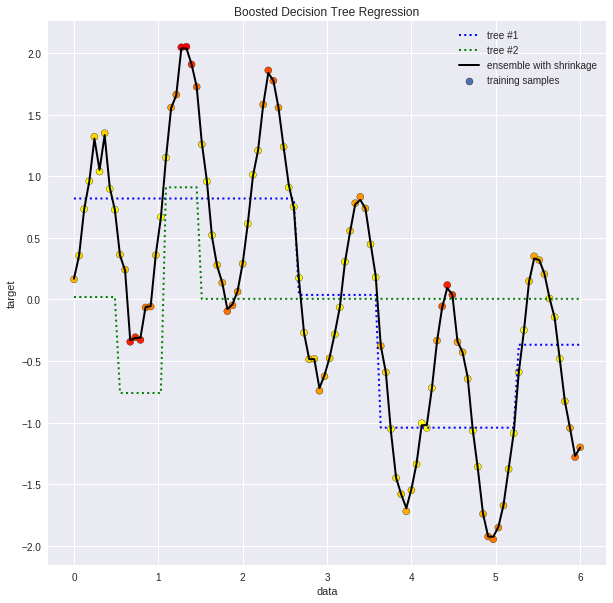

In [1083]:
# Fit regression model

regr_1 = DecisionTreeRegressor(max_depth=2)
#regr_2 = GradientBoostingRegressor('ls',
#                          n_estimators=2, random_state=rng)
regr_4 = GradientBoostingRegressor('ls', max_depth=2,
                          n_estimators=500, random_state=rng)

regr_1.fit(X, y)
# regr_2.fit(X, y)
regr_4.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
col = loss(y_1)
print(sum(col))

#regr_1.fit(X, y, sample_weight=col )
regr_1.fit(X, y - y_1)
y_2 = regr_1.predict(X)
col2 = 0.5*((y-y_2)**2)
print(sum(col2))

y_3 = ensemble(y_1, y_2, 0.1)
col3 = 0.5*((y-y_3)**2)
print(sum(col3))

y_4 = regr_4.predict(X)

# Plot the results
plt.figure()
plt.scatter(X, y, c=col, label="training samples", edgecolor="black",
            cmap=plt.get_cmap('autumn_r'))
plt.plot(X, y_1, linestyle=':', c="blue", label="tree #1", linewidth=2)
plt.plot(X, y_2, linestyle=':', c="green", label="tree #2", linewidth=2)
plt.plot(X, y_4, c="black", label="ensemble with shrinkage", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

0.67423489153


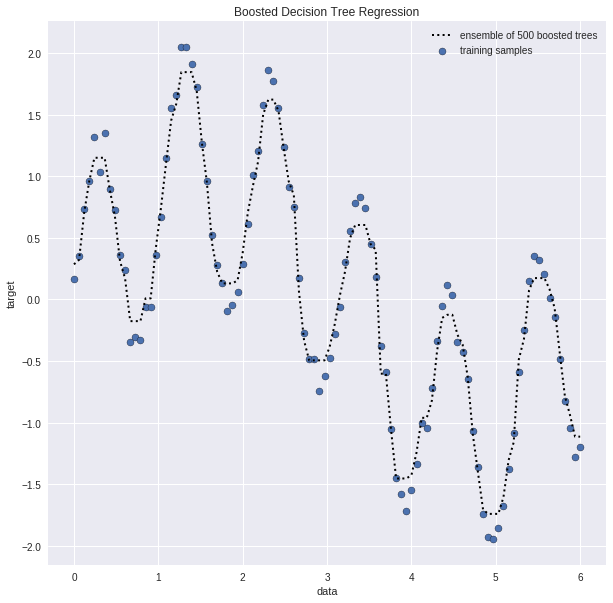

In [1085]:
col = col3
y_n = y_3
regr = DecisionTreeRegressor(max_depth=2)

for i in range(0, 100):
    regr.fit(X, y - y_n, sample_weight=col)
    y_o = regr.predict(X)
    y_n = ensemble(y_n, y_o, 0.1)
    col = loss(y_n)
    
print(sum(col))
# Plot the results
plt.figure()
plt.scatter(X, y, label="training samples", edgecolor="black")
plt.plot(X, y_n, c="black", linestyle=':', label="ensemble of 500 boosted trees", linewidth=2)
# plt.plot(X, y_2, linestyle=':', c="green", label="tree #2", linewidth=2)
# plt.plot(X, y_3, c="black", label="ensemble with shrinkage", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

# XGBoost vs LightGBM

## Original tree growth method:

|library|growth method|description|main complexity param|
|-|-|-|-|
|XGBoost|level-wise tree growth |next level nodes|`max_depth`|
|LightGBM|leaf-wise tree growth|node with highest max delta loss|`num_leaf`|
    
However, recently XGBoost has introduced `grow_policy` param, choosing `lossguide` will result in similar method as LightGBM.

### Tree depth for XGB (depthwise)

In [614]:
interact(do_xgb, depth=(2,4))

A Jupyter Widget

<function __main__.do_xgb>

### Max number of leafs in LightGBM (lossguide)

In [615]:
interact(do_lgb, leaf=(3,9,2))

A Jupyter Widget

<function __main__.do_lgb>

In [613]:
import xgboost as xgb
import graphviz
import os
from numpy import loadtxt
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

FEATURES = ['freq', 'attack_angle', 'chord_length',
            'free_stream_velocity', 'suction_side_thickness']

def load_data():
    dataset = pd.read_csv('foil.csv', sep=",")
    dataset = dataset[dataset.decibels > 0].reset_index()
    df_train = dataset[0:1200]
    df_test = dataset[1200:1503]
    y_train = df_train['decibels'].values
    y_test = df_test['decibels'].values
    omit_cols = ['index', 'decibels']    
    X_train = df_train.drop(omit_cols, axis=1).values
    X_test = df_test.drop(omit_cols, axis=1).values
    return y_train, y_test, X_train, X_test

In [562]:
def do_xgb(depth):
    y_train, y_test, X_train, X_test = load_data()
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_test = xgb.DMatrix(X_test, label=y_test)
    xgb_train.colnames = FEATURES
    xgb_test.colnames = FEATURES
    params = {'max_depth': depth, 'eta': 1, 'silent': 1,
              'objective': 'reg:linear', 'verbose_eval': False
             }
    model = xgb.train(params, xgb_train, 100)
    plot_tree(model, num_trees=1)
    plt.rcParams["figure.figsize"] = (40, 40)
    plt.show()
    
def do_lgb(leaf):
    y_train, y_test, X_train, X_test = load_data()    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    params = {
        'num_leaf': leaf,
        'metric': ('l1', 'l2'),
        'verbose': 0
    }
    evals_result = {}
    print('Start training...')
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=[lgb_train, lgb_test],
                    feature_name=FEATURES,
                    categorical_feature=[21],
                    evals_result=evals_result,
                    verbose_eval=50)
    print('Plot 1st tree...')
    ax = lgb.plot_tree(gbm, tree_index=83, 
                       show_info=['split_gain', 'internal_value',
                                  'internal_count', 'leaf_count']
                      )
    plt.rcParams["figure.figsize"] = (40, 40)
    plt.show()

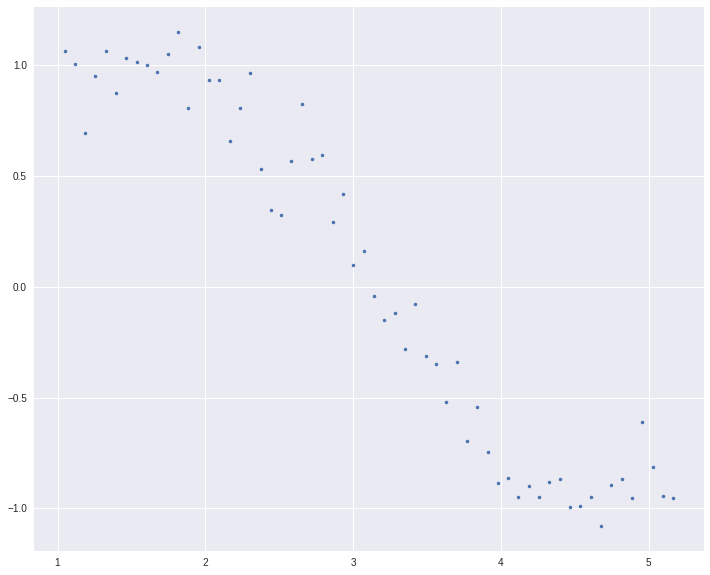

In [617]:
#Importing libraries. The same will be used throughout the article.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

In [406]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2       x_3       x_4       x_5       x_6  \
0  1.047198  1.065763  1.096623  1.148381  1.202581  1.259340  1.318778   
1  1.117011  1.006086  1.247713  1.393709  1.556788  1.738948  1.942424   
2  1.186824  0.695374  1.408551  1.671702  1.984016  2.354677  2.794587   
3  1.256637  0.949799  1.579137  1.984402  2.493673  3.133642  3.937850   
4  1.326450  1.063496  1.759470  2.333850  3.095735  4.106339  5.446854   

        x_7       x_8        x_9       x_10       x_11       x_12       x_13  \
0  1.381021  1.446202   1.514459   1.585938   1.660790   1.739176   1.821260   
1  2.169709  2.423588   2.707173   3.023942   3.377775   3.773011   4.214494   
2  3.316683  3.936319   4.671717   5.544505   6.580351   7.809718   9.268760   
3  4.948448  6.218404   7.814277   9.819710  12.339811  15.506664  19.486248   
4  7.224981  9.583578  12.712139  16.862020  22.366630  29.668222  39.353420   

        x_14       x_15  
0   1.907219   1.997235  
1   4.707635   5